# Extract-Transform-Load Notebook

## Extraction & Exploration
Dataset is available on kaggle. This notebook assumes it's stored in a directory `../datasets/diabetes.csv`.
***

In [1]:
# setup environment
# !pip install -r ../requirements.txt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from utils.explore_dataset import *
from utils.transform_dataset import *
from utils.dataset import *

### Initial Exploration

In [2]:
# load in dataset
ds = Dataset(
    path="../datasets/diabetes.csv"
)

# initial preparation
standardize_column_names(ds.data, inplace=True)
ds.data.rename(columns={
    "diabetes_012": "diabetes",
    "high_b_p": "high_bp",
    "b_m_i": "bmi",
    "heart_diseaseor_attack": "heart_disease",
    "phys_activity": "physical_activity",
    "hvy_alcohol_consump": "heavy_drinker",
    "any_healthcare": "healthcare",
    "no_docbc_cost": "no_doc_bc_cost",
    "gen_hlth": "general_health",
    "ment_hlth": "mental_health",
    "phys_hlth": "physical_health",
}, inplace=True)

In [3]:
# define key features; we'll assume all features are used initially
ds.set_target(target="diabetes")

In [4]:
# data intactness & inference
check_integrity(ds.data, remove_na=True, inplace=True)
ds.infer_types(apply_inference=True)

numeric_cols_summary = f"<Numeric Summary>\n\t" + "\n\t".join(ds.numeric_features)
ordinal_cols_summary = f"<Ordinal Summary>\n\t" + "\n\t".join(ds.ordinal_features)
nominal_cols_summary = f"<Nominal Summary>\n\t" + "\n\t".join(ds.nominal_features)
print(numeric_cols_summary)
print(ordinal_cols_summary)
print(nominal_cols_summary)

<Checking Data Integrity>
	Checking <diabetes>...            	<cleared>
	Checking <high_bp>...             	<cleared>
	Checking <high_chol>...           	<cleared>
	Checking <chol_check>...          	<cleared>
	Checking <bmi>...                 	<cleared>
	Checking <smoker>...              	<cleared>
	Checking <stroke>...              	<cleared>
	Checking <heart_disease>...       	<cleared>
	Checking <physical_activity>...   	<cleared>
	Checking <fruits>...              	<cleared>
	Checking <veggies>...             	<cleared>
	Checking <heavy_drinker>...       	<cleared>
	Checking <healthcare>...          	<cleared>
	Checking <no_doc_bc_cost>...      	<cleared>
	Checking <general_health>...      	<cleared>
	Checking <mental_health>...       	<cleared>
	Checking <physical_health>...     	<cleared>
	Checking <diff_walk>...           	<cleared>
	Checking <sex>...                 	<cleared>
	Checking <age>...                 	<cleared>
	Checking <education>...           	<cleared>
	Checkin

In [5]:
# numerical exploration
numerical_summary(ds.data)

<Peak Dataset>
   diabetes  high_bp  high_chol  chol_check   bmi  smoker  stroke  \
0         0        1          1           1  40.0       1       0   
1         0        0          0           0  25.0       1       0   
2         0        1          1           1  28.0       0       0   
3         0        1          0           1  27.0       0       0   
4         0        1          1           1  24.0       0       0   

   heart_disease  physical_activity  fruits  ...  healthcare  no_doc_bc_cost  \
0              0                  0       0  ...           1               0   
1              0                  1       0  ...           0               1   
2              0                  0       1  ...           1               1   
3              0                  1       1  ...           1               0   
4              0                  1       1  ...           1               0   

   general_health  mental_health  physical_health  diff_walk  sex   age  \
0             

In [6]:
# identify feature types
categorical_features = []

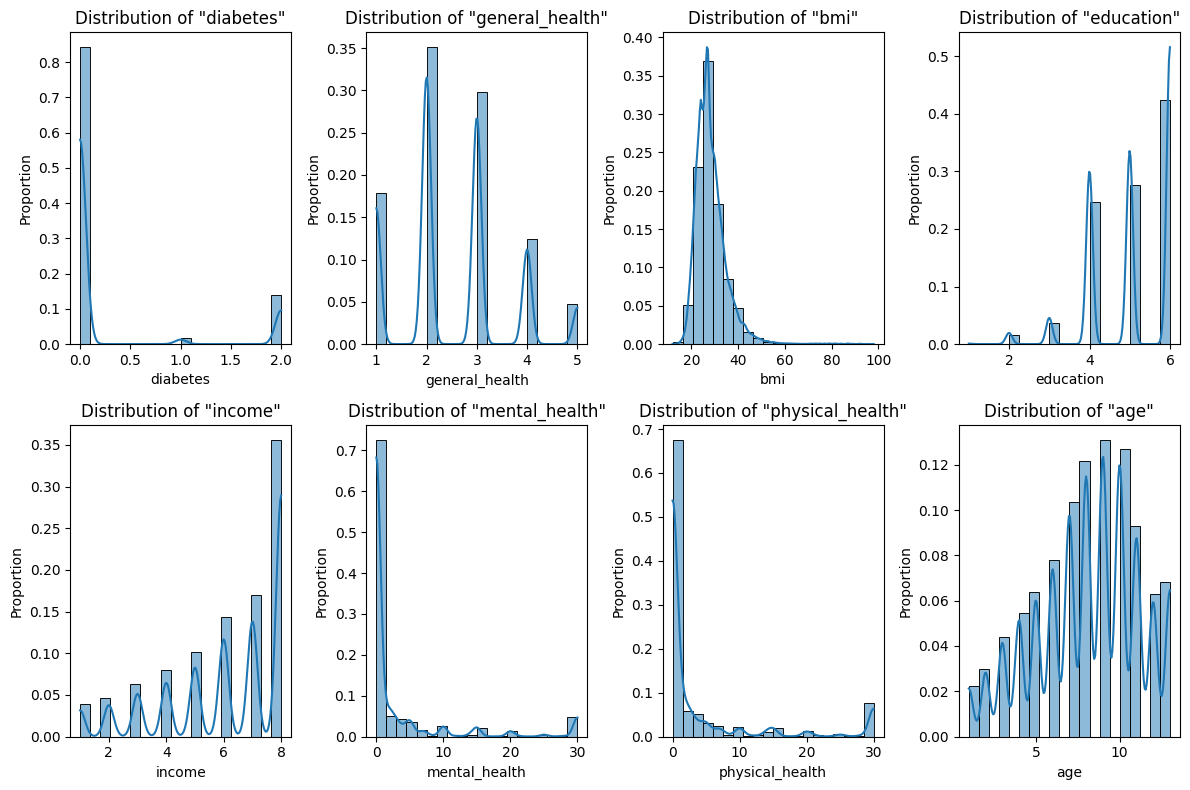

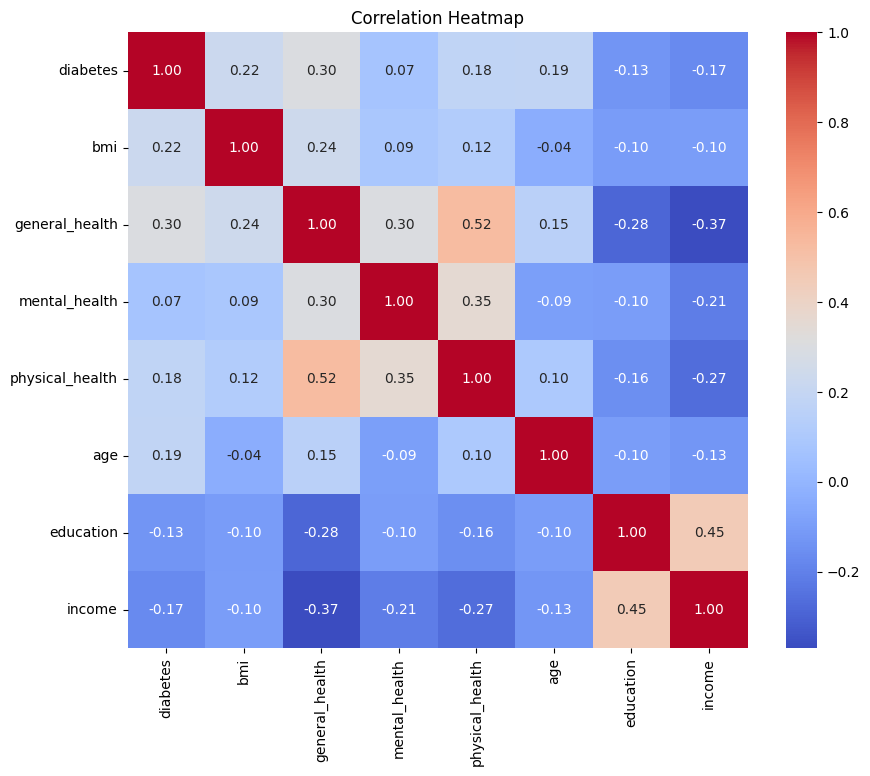

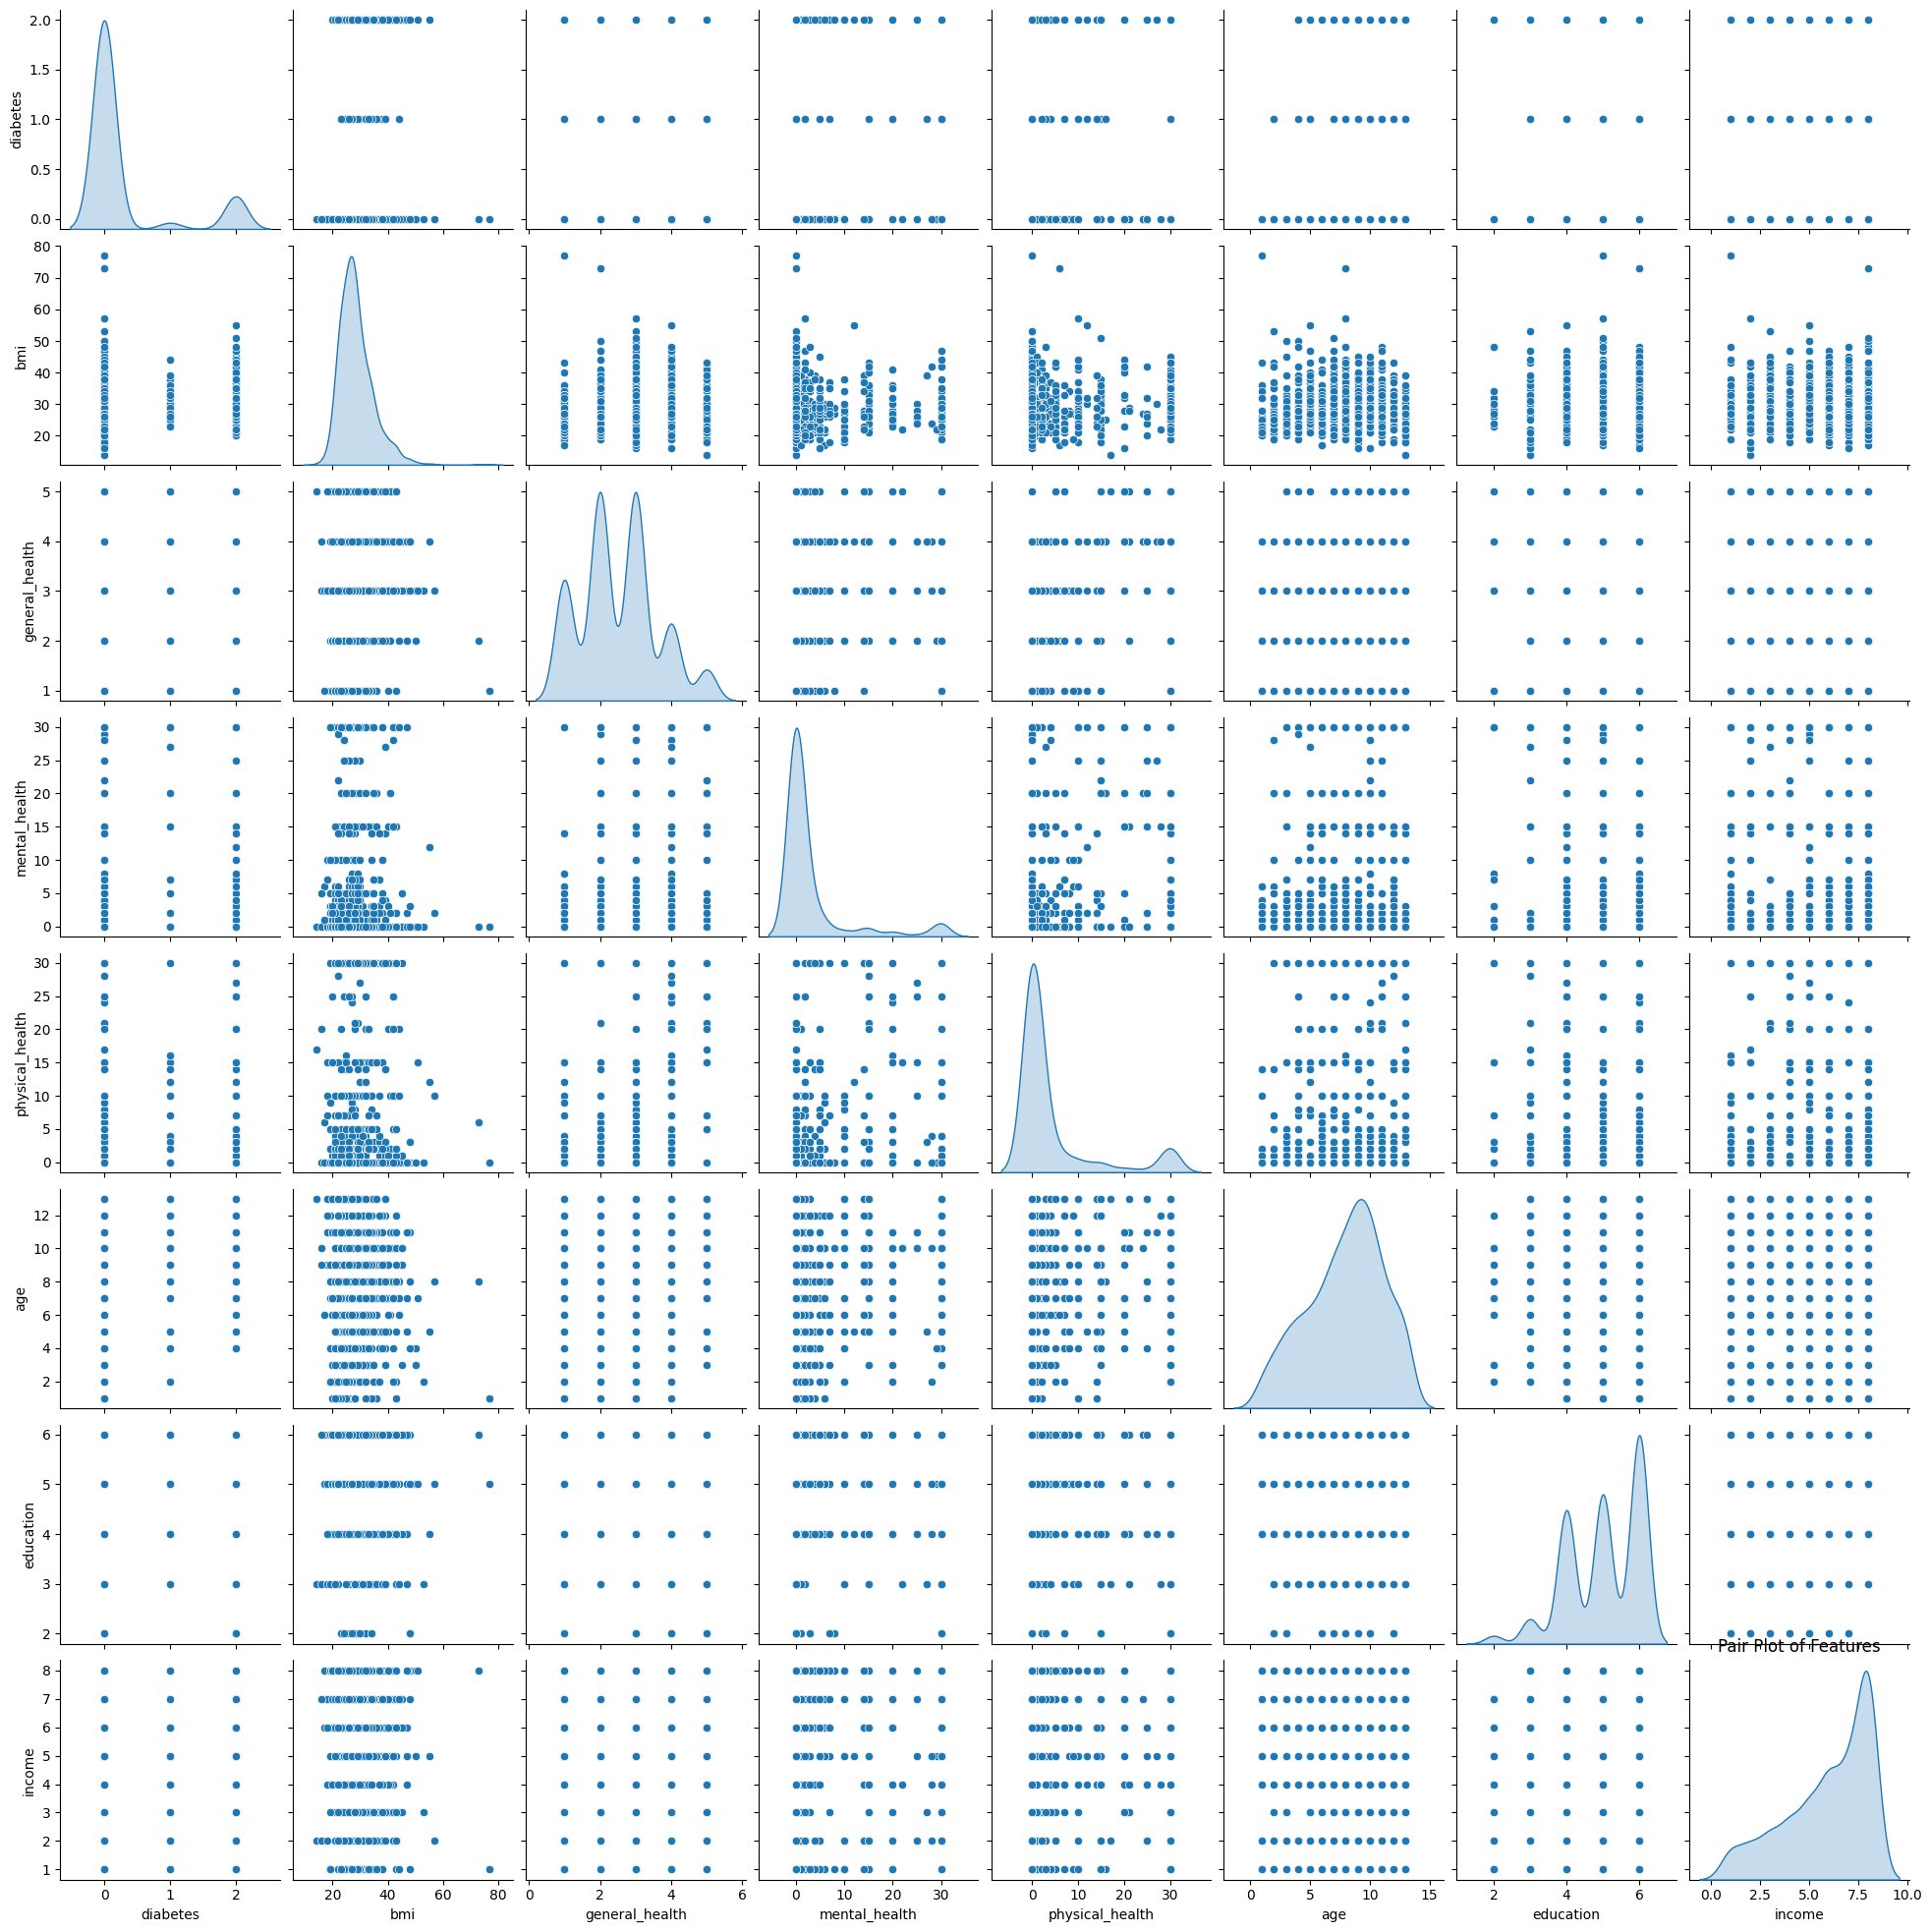

In [7]:
# visualizations
visualize_distributions(ds.data, cols=4, ignore_binary=True)
visualize_relationships(ds.data)

In [8]:
# target feature exploration
label_counts = target_explorations(ds.data, ds.target)
label_counts = {k: f"{v / ds.data.shape[0] * 100:.4f}%" for k, v in label_counts.items()}
print(label_counts)


<Target Distribution "diabetes">
Label `0` has 213703 observations ==> <WARNING> outside of balanced range of observations
Label `2` has 35346 observations ==> <WARNING> outside of balanced range of observations
Label `1` has 4631 observations ==> <WARNING> outside of balanced range of observations
{0: '84.2412%', 2: '13.9333%', 1: '1.8255%'}


## Transformation
Our work in the exploratory phase revealed a few key things:
1. There's not much data to clean, it's already very intact
2. There's a large imbalance in target labels, especially an overabundance of non-diabetes (84%) compared to with diabetes (2%).
3. The features are mostly categorically based (even normally numeric ones like `income` have been converted to a category (likely through some binning process))
4. There are a few features with slightly high correlations, but most features are non-collinear so we can use the majority of them if needed
5. In terms of outliers, there seems to be very few **<-- ENSURE THIS IS CORRECT**

As such, during the transformation phase we have a few goals in mind:
1. One-Hot encode the non-ordinal, but still categorical features
    1. If the feature is ordinal, we can assume a somewhat linear relationship already and avoid encoding in any form since there is a relationship between each level
    2. If there exists an ordinal feature that we can't assume a linear relationship for, we can also one-hot encode (but NN should capture non-linear trends so this may not be necessary)
    3. If the feature is non-ordinal, we can't assume any kind of inequality between labels, so we should enforce one-hot encoding on them
2. Narrow down our feature-set
    1. First, we'll remove the highly correlated features by either combining them or choosing the one with a better correlation with our target feature
    2. Then, we'll run logistic ridge regression as a base model to (i) get a baseline for our later ANN modeling and (ii) see which features are selected out via a near-zero coefficient after applying an L2 penalty
    3. Based on these two methods, we can reduce our feature count to only the most essential features
3. Up-Sample the positive (diabetes) and half-positive (pre-diabetes) labels so we don't create imbalanced training down the line
    1. We can either combine pre-diabetes and diabetes labels prior to upsampling or keep the multi-label context
    2. Since there are far too few diabetes observations and far too many non-diabetes observations, it's best to up-sample and not down-sample to avoid wasting the large amount of data we have for non-diabetes patients
    3. NOTE: we should be wary when modeling to extra penalize the positive label being incorrect and use F1-score over accuracy for measuring performance due to this imbalance
4. Standardize the numeric features (using Min-Max or Z-Score)

In [ ]:
"""
    One-Hot Encoding & Standardization:
"""

# One-Hot Encoding
features_to_encode = ["education"]
ds.one_hot_encode(features_to_encode)

# Standardization
ds.normalize_features(features=ds.numeric_features, how="minmax")

# re-check
numerical_summary(ds.data)

In [ ]:
"""
    Feature Selection: we only want to select features with low collinearity 
    with other features and a strong relationship with the target variable. To 
    do this, we can re-consult the correlation matrix (except now include 
    categorical features) and check the correlations with the target feature.
"""

"""
    Up-Sampling: 
"""